In [7]:
# --- 1. 라이브러리 및 모듈 임포트 ---

# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 도구
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# 변수 중요도 확인 및 모델 해석
import eli5
from eli5.sklearn import PermutationImportance

# 시스템 및 경로 관련 라이브러리
import sys
import os
from datetime import datetime
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (baseline_code.ipynb 참고)
# Colab 또는 로컬 환경에 맞게 경로를 설정해야 할 수 있습니다.
import matplotlib.font_manager as fm
try:
    fe = fm.FontEntry(
        fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        name='NanumBarunGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
    plt.rc('font', family='NanumBarunGothic')
except FileNotFoundError:
    print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
    pass

In [2]:
# --- 2. 경로 설정 및 커스텀 로거 임포트 ---

# 현재 노트북 파일의 위치를 기준으로 프로젝트 루트 경로를 설정합니다.
# (예: notebooks 폴더에 있다면 ../../src 가 맞습니다)
try:
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
    sys.path.insert(0, src_path)
    from logger import Logger
    print("Logger 모듈 로드 성공.")
except ImportError:
    print("[오류] Logger 모듈을 찾을 수 없습니다. src/log/logger.py 경로를 확인해주세요.")
    # Logger가 없어도 코드가 중단되지 않도록 임시 클래스 정의
    class Logger:
        def __init__(self, *args, **kwargs): pass
        def write(self, message, **kwargs): print(message)

Logger 모듈 로드 성공.


In [9]:
# --- 3. 로거 및 경로 초기화 ---

# 로그 파일이 저장될 경로 설정
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR         = '../../data/logs/price_prediction_logs'
LOG_FILENAME    = f"price_prediction_{timestamp}.log"
LOG_PATH        = os.path.join(LOG_DIR, LOG_FILENAME)

# Directory 생성
os.makedirs(LOG_DIR, exist_ok=True)

# Logger 인스턴스 생성
logger = Logger(log_path=LOG_PATH)

# 데이터 및 제출 파일 경로 설정
DATA_PATH = '../../data/processed/cleaned_data/test_clean.csv'
SUBMISSION_DIR = '../../data/processed/submissions'
SUBMISSION_FILENAME = 'price_prediction_submission.csv'
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME)

logger.write("="*50)
logger.write(">> 아파트 가격 예측 모델링 시작")

2025-07-14 07:05:16 | ==================================================
2025-07-14 07:05:16 | >> 아파트 가격 예측 모델링 시작


In [10]:
# --- 4. 데이터 로드 ---

logger.write(">> 정제된 Train/Test 데이터를 로드합니다...")
try:
    # 학습 데이터와 테스트 데이터를 각각 로드
    train_df_clean = pd.read_csv('../../data/processed/cleaned_data/train_clean.csv')
    test_df_clean = pd.read_csv('../../data/processed/cleaned_data/test_clean.csv')
    
    # 두 데이터를 합치기 전에 isTest 컬럼으로 구분
    train_df_clean['isTest'] = 0
    test_df_clean['isTest'] = 1
    
    # 하나의 데이터프레임으로 합침
    df = pd.concat([train_df_clean, test_df_clean])
    
    logger.write(">> 데이터 로드 및 병합 완료.")
except FileNotFoundError:
    logger.write(f">> [오류] train_clean.csv 또는 test_clean.csv 파일을 찾을 수 없습니다.", print_error=True)
    df = None

2025-07-14 07:06:02 | >> 정제된 Train/Test 데이터를 로드합니다...
2025-07-14 07:06:04 | >> 데이터 로드 및 병합 완료.


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


2025-07-14 07:06:07 | >> 주요 변수 데이터 분포 시각화를 시작합니다...


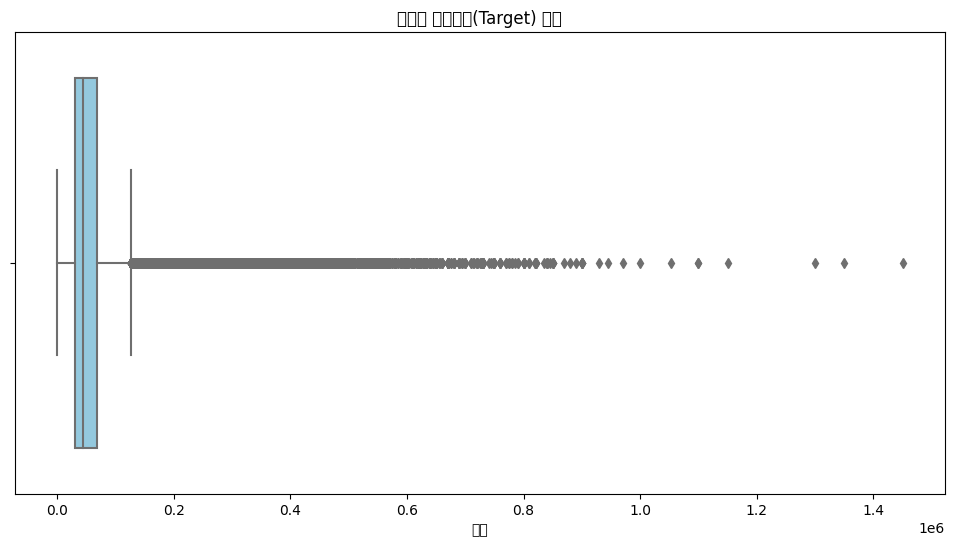

ValueError: Could not interpret input '전용면적(㎡)'

<Figure size 1200x600 with 0 Axes>

In [11]:
# --- 5. 데이터 시각화 (추가된 부분) ---
if df is not None:
    logger.write(">> 주요 변수 데이터 분포 시각화를 시작합니다...")
    
    # 실거래가(Target) 분포 확인
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train_df_clean, x='target', color='skyblue')
    plt.title('아파트 실거래가(Target) 분포')
    plt.xlabel('가격')
    plt.show()

    # 전용 면적 분포 확인
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='전용면적(㎡)', color='lightgreen')
    plt.title('전용면적 분포')
    plt.xlabel('면적(㎡)')
    plt.show()

In [12]:
# --- 6. 특성 공학 (Feature Engineering) (추가된 부분) ---
if df is not None:
    logger.write(">> 특성 공학을 통해 파생 변수를 생성합니다...")
    
    # '시군구' 변수에서 '구', '동' 추출
    df['구'] = df['시군구'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else '정보없음')
    df['동'] = df['시군구'].apply(lambda x: x.split()[2] if len(x.split()) > 2 else '정보없음')
    df = df.drop('시군구', axis=1) # 기존 컬럼 삭제

    # '계약년월'에서 '계약년', '계약월' 추출
    df['계약년'] = df['계약년월'].astype(str).str[:4]
    df['계약월'] = df['계약년월'].astype(str).str[4:]
    df = df.drop('계약년월', axis=1)

    # 강남 여부 파생변수 생성
    gangnam_gu = ['강남구', '서초구', '송파구']
    df['강남여부'] = df['구'].apply(lambda x: 1 if x in gangnam_gu else 0)

    # 신축 여부 파생변수 생성 (예: 2015년 이후 건축 시 신축으로 판단)
    df['신축여부'] = df['건축년도'].apply(lambda x: 1 if x >= 2015 else 0)

    logger.write(">> 파생 변수 생성 완료: 구, 동, 계약년, 계약월, 강남여부, 신축여부")

2025-07-14 07:07:24 | >> 특성 공학을 통해 파생 변수를 생성합니다...


KeyError: '시군구'

In [13]:
# --- 7. 피처 선택 및 데이터 분리 ---

if df is not None:
    try:
        # isTest 컬럼을 사용해 train/test 데이터 분리
        train_df = df[df['isTest'] == 0].copy()
        test_df = df[df['isTest'] == 1].copy()
        train_df = train_df.drop('isTest', axis=1)
        test_df = test_df.drop('isTest', axis=1)
        logger.write(">> Train/Test 데이터 분리 완료.")

        # 예측에 사용할 피처(X)와 타겟(y) 정의
        # target이 test_df에는 없으므로 train_df에서 피처 목록을 만듭니다.
        features = [col for col in train_df.columns if col != 'target']
        
        X_train_raw = train_df[features]
        y_train = train_df['target']
        X_test_raw = test_df[features]

        # 범주형(object) 피처 자동 탐지
        categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()
        
        logger.write(f">> 예측에 사용할 피처 개수: {len(features)}개")
        logger.write(f">> 범주형 피처: {categorical_features}")
    except Exception as e:
        logger.write(f">> [오류] 피처 선택 및 데이터 분리 중 문제 발생: {e}", print_error=True)

2025-07-14 07:07:54 | >> Train/Test 데이터 분리 완료.
2025-07-14 07:07:54 | >> 예측에 사용할 피처 개수: 28개
2025-07-14 07:07:54 | >> 범주형 피처: ['계약일자', '자치구', '법정동', '브랜드등급', '지하철최단거리', '반경_1km_지하철역_수', '반경_500m_지하철역_수', '반경_300m_지하철역_수', '버스최단거리', '반경_1km_버스정류장_수', '반경_500m_버스정류장_수', '반경_300m_버스정류장_수']


In [14]:
# --- 8. 범주형 피처 인코딩 ---

if 'X_train_raw' in locals():
    try:
        # LabelEncoder를 사용하여 각 범주형 피처를 수치로 변환
        label_encoders = {}
        for col in categorical_features:
            le = LabelEncoder()
            all_categories = pd.concat([X_train_raw[col], X_test_raw[col]]).astype(str).unique()
            le.fit(all_categories)
            
            X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
            X_test_raw[col] = le.transform(X_test_raw[col].astype(str))
            label_encoders[col] = le
        logger.write(">> 범주형 피처 Label Encoding 완료.")
    except Exception as e:
        logger.write(f">> [오류] 범주형 피처 인코딩 중 문제 발생: {e}", print_error=True)

2025-07-14 07:09:16 | >> 범주형 피처 Label Encoding 완료.


In [15]:
# --- 9. 모델 학습 및 평가 (개선된 부분) ---

if 'X_train_raw' in locals():
    try:
        # 학습 데이터를 다시 train/validation 세트로 분리
        X_train, X_val, y_train_split, y_val_split = train_test_split(
            X_train_raw, y_train, test_size=0.2, random_state=42
        )

        # LightGBM 모델 학습
        logger.write(">> LightGBM 모델 학습을 시작합니다...")
        lgbm = lgb.LGBMRegressor(random_state=42)
        lgbm.fit(X_train, y_train_split)

        # 검증 데이터셋에 대한 예측 및 성능 평가
        y_pred = lgbm.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        logger.write(f">> 모델 학습 완료. Validation RMSE: {rmse:.4f}")

        # Permutation Importance를 사용한 변수 중요도 확인 (추가)
        logger.write(">> Permutation Importance를 계산합니다...")
        perm = PermutationImportance(lgbm, scoring='neg_mean_squared_error', random_state=42, n_iter=3).fit(X_val, y_val_split)
        
        # eli5를 사용하여 변수 중요도를 시각적으로 표시
        display(eli5.show_weights(perm, feature_names=X_val.columns.tolist()))
        
    except Exception as e:
        logger.write(f">> [오류] 모델 학습 및 평가 중 문제 발생: {e}", print_error=True)

2025-07-14 07:09:40 | >> LightGBM 모델 학습을 시작합니다...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 878273, number of used features: 28
[LightGBM] [Info] Start training from score 57582.439147
2025-07-14 07:09:41 | >> 모델 학습 완료. Validation RMSE: 12749.2160
2025-07-14 07:09:41 | >> Permutation Importance를 계산합니다...


Weight,Feature
1122908133.0448 ± 4025059.1738,전용면적
272773783.2616 ± 2974720.7160,계약일자
239694690.8365 ± 3872091.7757,강남3구여부
214994112.7433 ± 3283105.1882,성비(남/여)
170703881.5134 ± 2948858.5260,연식
119221767.2365 ± 1236588.6631,자치구
99713882.0514 ± 2692038.7372,계약년월
55391010.2731 ± 458486.7921,법정동
52689442.6898 ± 268323.2115,총인구수
38231102.7476 ± 659885.8120,아파트이름길이


In [16]:
# --- 10. 예측 오차 분석 (Error Analysis) (추가된 부분) ---

if 'X_val' in locals():
    logger.write(">> 예측 오차 분석을 시작합니다...")
    X_val_analysis = X_val.copy()
    X_val_analysis['target'] = y_val_split
    X_val_analysis['pred'] = y_pred
    X_val_analysis['error'] = (X_val_analysis['target'] - X_val_analysis['pred']) ** 2

    # 오차가 큰 상위 100개와 작은 상위 100개 데이터 분리
    error_top100 = X_val_analysis.sort_values(by='error', ascending=False).head(100)
    best_top100 = X_val_analysis.sort_values(by='error', ascending=True).head(100)
    
    # '전용면적' 분포 비교 시각화
    plt.figure(figsize=(12, 6))
    sns.histplot(data=error_top100, x='전용면적(㎡)', color='red', alpha=0.5, label='오차 상위 100')
    sns.histplot(data=best_top100, x='전용면적(㎡)', color='blue', alpha=0.5, label='오차 하위 100')
    plt.title('예측 오차에 따른 전용면적 분포 비교')
    plt.legend()
    plt.show()

2025-07-14 07:10:19 | >> 예측 오차 분석을 시작합니다...


ValueError: Could not interpret value `전용면적(㎡)` for parameter `x`

<Figure size 1200x600 with 0 Axes>

In [ ]:
# --- 11. 최종 예측 및 제출 파일 생성 ---
if 'X_train_raw' in locals():
    logger.write("\n>> 최종 모델 학습 및 제출 파일 생성을 시작합니다...")
    try:
        # 전체 학습 데이터로 최종 모델 재학습
        final_model = lgb.LGBMRegressor(random_state=42)
        final_model.fit(X_train_raw, y_train)
        
        # 테스트 데이터에 대한 예측 수행
        final_predictions = final_model.predict(X_test_raw)
        
        # 제출 파일 생성
        try:
            sample_submission_df = pd.read_csv(SUBMISSION_PATH)
            sample_submission_df['target'] = final_predictions
            sample_submission_df.to_csv(SUBMISSION_PATH, index=False)
        except FileNotFoundError:
            logger.write(">> sample_submission.csv 파일을 찾을 수 없어 새로 생성합니다.", print_error=True)
            submission_df = pd.DataFrame({'target': final_predictions})
            submission_df.to_csv(SUBMISSION_PATH, index=False)
            
        logger.write(f">> 제출 파일 '{SUBMISSION_PATH}' 생성 완료.")
    except Exception as e:
        logger.write(f">> [오류] 최종 예측 및 제출 파일 생성 중 문제 발생: {e}", print_error=True)
    
    logger.write(">> 모델링 종료")
    logger.write("="*50 + "\n")